
##Major Project I Semester 7
### Speech Sentiment Analysis
###Team Members : Sameer Mishra | Sushant Kumar | Yash Jalan 
###Team Mentor : Dr. Pulkit Mehndiratta


###Importing Relevant Libraries

In [11]:
import pandas as pd
import numpy as np

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [12]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical


In [14]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

###Data Preprocessing

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####Using the Ravdess and CREMA data set, stored in the google drive

In [16]:
Ravdess = '/content/gdrive/MyDrive/DS/'
crema = '/content/gdrive/MyDrive/CREMA/AudioWAV/'

In [17]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    
    actor = os.listdir(Ravdess +dir)

    for file in actor:
    
        part = file.split('.')[0]
        part = part.split('-')
       
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
1  neutral  /content/gdrive/MyDrive/DS/Actor_24/03-02-01-0...
2     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
3     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
4  neutral  /content/gdrive/MyDrive/DS/Actor_24/03-02-01-0...

In [18]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0     fear  /content/gdrive/MyDrive/CREMA/AudioWAV/1079_WS...
1  disgust  /content/gdrive/MyDrive/CREMA/AudioWAV/1080_DF...
2  neutral  /content/gdrive/MyDrive/CREMA/AudioWAV/1079_TS...
3      sad  /content/gdrive/MyDrive/CREMA/AudioWAV/1079_WS...
4  disgust  /content/gdrive/MyDrive/CREMA/AudioWAV/1079_TS...

In [19]:
data_set = pd.concat([Ravdess_df, Crema_df], axis = 0)
data_set.to_csv("data_set.csv",index=False)
data_set.head()

Emotions                                               Path
0     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
1  neutral  /content/gdrive/MyDrive/DS/Actor_24/03-02-01-0...
2     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
3     calm  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
4  neutral  /content/gdrive/MyDrive/DS/Actor_24/03-02-01-0...

In [20]:
data_set.describe()

Emotions                                               Path
count      8843                                               8843
unique        8                                               8843
top         sad  /content/gdrive/MyDrive/DS/Actor_24/03-02-02-0...
freq       1468                                                  1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


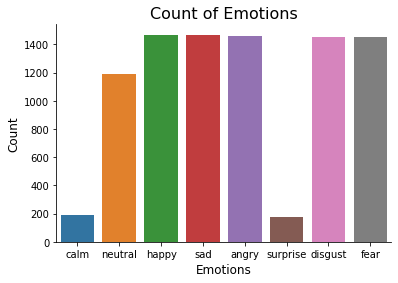

In [21]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_set.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In the above countplot, we have less data for calm and surprised emotion, this may cause some issues

In [47]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 4))
    plt.title('Waveplot for audio with {} emotion'.format(e))
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 5))
    plt.title('Spectrogram for audio with {} emotion'.format(e))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()
    

def create_fft_plot(data,sr,e):
  fft = np.fft.fft(data)
  magnitude = np.abs(fft) 
  frequency = np.linspace(0,22050,len(magnitude))
  left_frequency = frequency[:int(len(frequency)/2)]
  left_mag = magnitude[:int(len(magnitude)/2)]
  plt.figure(figsize = (7,4))
  plt.plot(left_frequency,left_mag)
  plt.title("FFT for audio with {} emotion".format(e))
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  
  plt.show()

In [48]:
def plots_for_emotion(emotion):
  path = np.array(data_set.Path[data_set.Emotions==emotion])[1]
  data,sampling_rate = librosa.load(path)
  create_waveplot(data,sampling_rate,emotion)
  create_fft_plot(data,sampling_rate,emotion)
  create_spectrogram(data, sampling_rate, emotion)
  return path


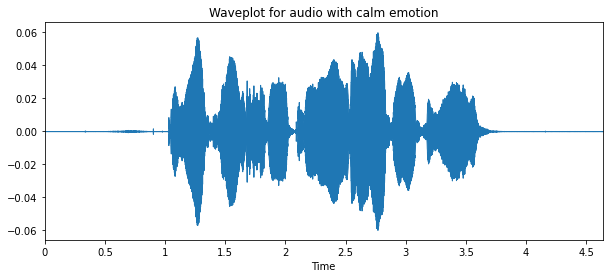

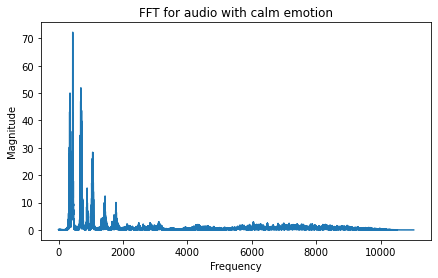

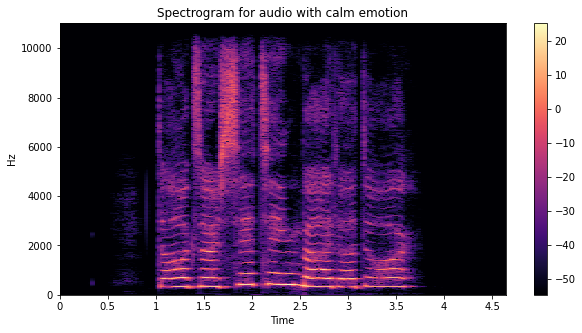

In [49]:
path = plots_for_emotion('calm')
Audio(path)

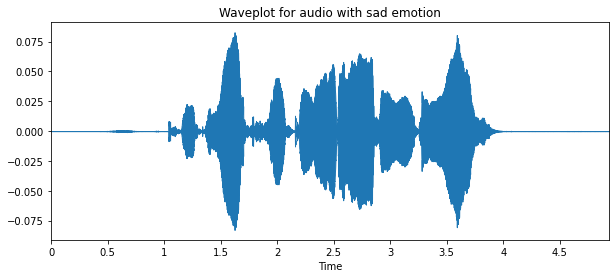

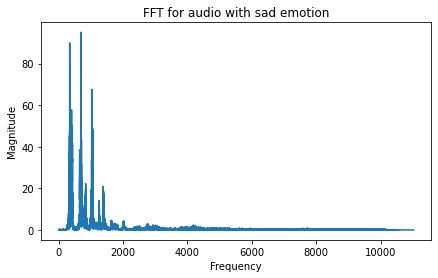

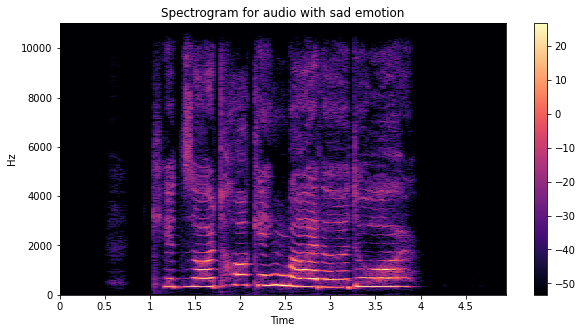

In [50]:
path = plots_for_emotion('sad')
Audio(path)

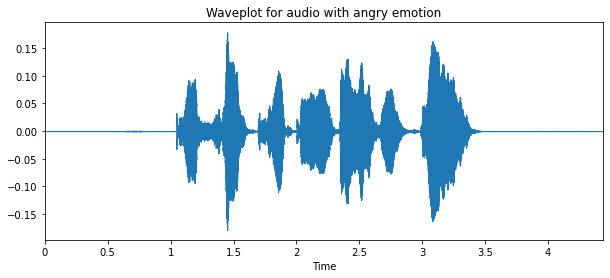

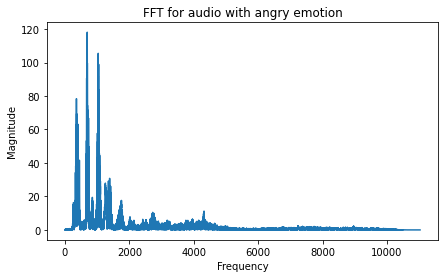

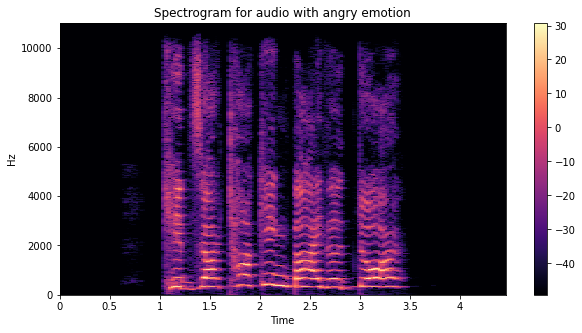

In [51]:
path = plots_for_emotion('angry')
Audio(path)

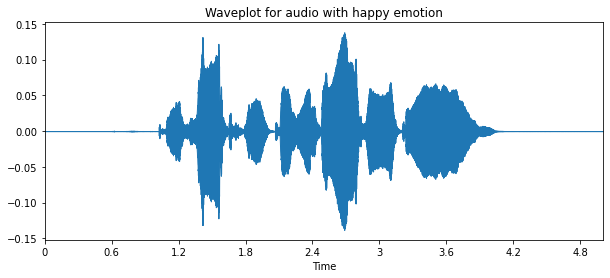

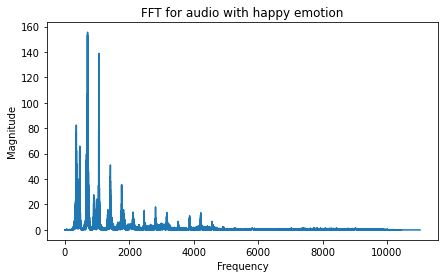

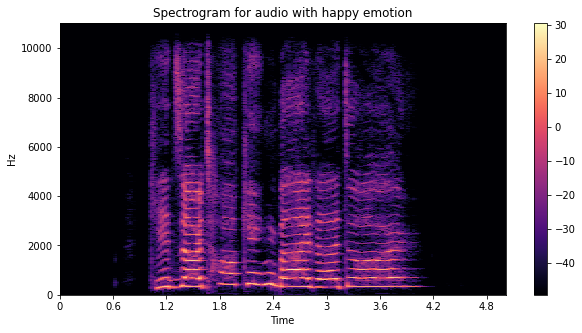

In [52]:
path = plots_for_emotion('happy')
Audio(path)

###Data Augmentation 

In [27]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

path = np.array(data_set.Path)[1]
data, sample_rate = librosa.load(path)

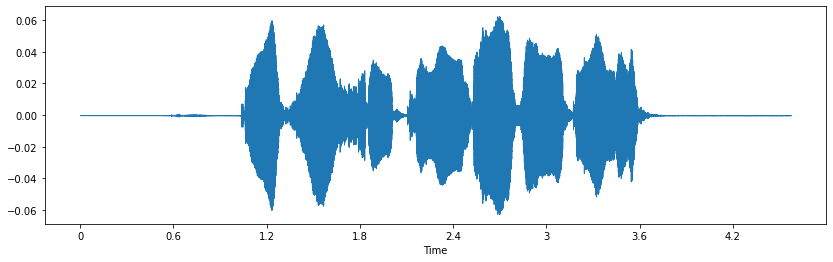

In [28]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

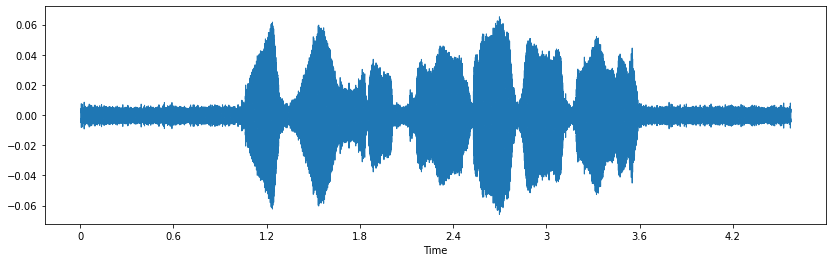

In [29]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

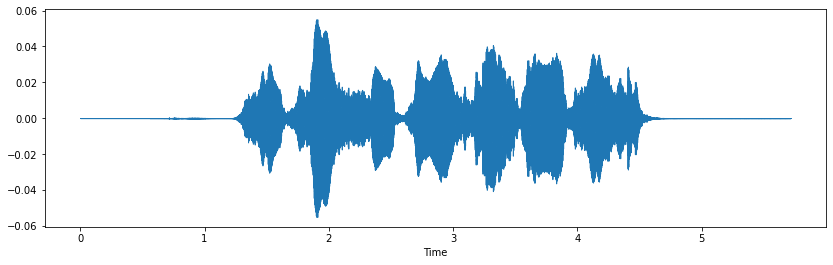

In [30]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


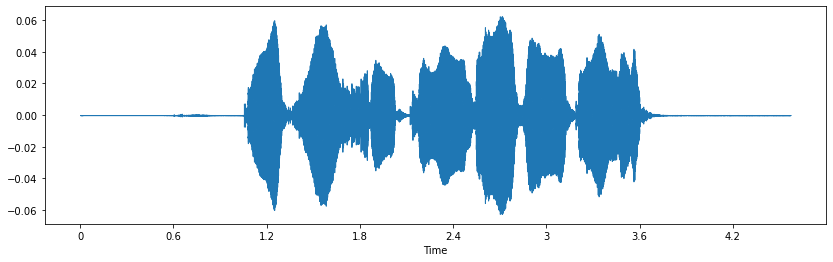

In [31]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


###Extracting Features.
The features which we will be extracting are:

ZCR : The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive.ZCR can be interpreted as a measure of the noisiness of a signal. For example, it usually exhibits higher values in the case of noisy signals.

Chroma_stft : The Chroma value of an audio basically represent the intensity of the twelve distinctive pitch classes that are used to study music.

MFCC : The Chroma value of an audio basically represent the intensity of the twelve distinctive pitch classes that are used to study music.

RMSV : Here, it acts as an indicator of loudness, since higher the energy, louder the sound.


In [32]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

###Building the model

In [33]:
X, Y = [], []
for path, emotion in zip(data_set.Path, data_set.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [34]:
len(X), len(Y), data_set.Path.shape

(26529, 26529, (8843,))

In [35]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.268753  0.404700  0.356314  0.458777  0.460243  0.324030  0.329716   
1  0.272552  0.487300  0.383099  0.449145  0.541632  0.443737  0.344494   
2  0.229199  0.661002  0.361576  0.285938  0.392784  0.437887  0.286469   
3  0.238892  0.569910  0.396257  0.238621  0.201055  0.201196  0.269897   
4  0.270767  0.525891  0.602090  0.379193  0.317052  0.300561  0.296413   

          7         8         9  ...       153       154       155       156  \
0  0.371971  0.337937  0.341717  ...  0.000172  0.000072  0.000023  0.000053   
1  0.361224  0.345443  0.355808  ...  0.000175  0.000074  0.000026  0.000057   
2  0.304032  0.365713  0.342547  ...  0.000030  0.000059  0.000035  0.000011   
3  0.221780  0.234226  0.217760  ...  0.000076  0.000035  0.000010  0.000023   
4  0.318585  0.253650  0.257833  ...  0.000242  0.000189  0.000152  0.000167   

        157       158       159           160           161   labels  
0  0.000070  0.000013  0.000003  5.868539e-07  1.667507e-07     calm  
1  0.000076  0.000015  0.000005  3.150451e-06  2.849233e-06     calm  
2  0.000004  0.000011  0.000002  4.357957e-08  2.726293e-09     calm  
3  0.000032  0.000009  0.000002  5.401548e-07  3.211373e-07  neutral  
4  0.000196  0.000166  0.000173  1.571290e-04  1.365789e-04  neutral  

[5 rows x 163 columns]

In [36]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19896, 162), (19896, 8), (6633, 162), (6633, 8))

In [37]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19896, 162), (19896, 8), (6633, 162), (6633, 8))

In [38]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19896, 162, 1), (19896, 8), (6633, 162, 1), (6633, 8))

In [39]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(x_train.shape[1],1))) 
model.add(Activation('relu'))

model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1])) # Target class number
model.add(Activation('softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 162, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 162, 256)          524544    
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 162, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 162, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 256)           0

In [40]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/40
311/311 [==============================] - 358s 1s/step - loss: 1.6275 - accuracy: 0.3319 - val_loss: 1.7762 - val_accuracy: 0.2907
Epoch 2/40
311/311 [==============================] - 354s 1s/step - loss: 1.5028 - accuracy: 0.3880 - val_loss: 1.5670 - val_accuracy: 0.3401
Epoch 3/40
311/311 [==============================] - 355s 1s/step - loss: 1.4431 - accuracy: 0.4134 - val_loss: 1.6699 - val_accuracy: 0.3053
Epoch 4/40
311/311 [==============================] - 356s 1s/step - loss: 1.4045 - accuracy: 0.4308 - val_loss: 1.5016 - val_accuracy: 0.3780
Epoch 5/40
311/311 [==============================] - 353s 1s/step - loss: 1.3737 - accuracy: 0.4486 - val_loss: 1.4647 - val_accuracy: 0.4007
Epoch 6/40
311/311 [==============================] - 353s 1s/step - loss: 1.3456 - accuracy: 0.4614 - val_loss: 1.4854 - val_accuracy: 0.4001
Epoch 7/40
311/311 [==============================] - 355s 1s/step - loss: 1.3130 - accuracy: 0.4754 - val_loss: 1.3868 - val_accuracy: 0.4417

###Predicting the outcome

208/208 [==============================] - 24s 113ms/step - loss: 1.4906 - accuracy: 0.6021
Accuracy of our model on test data :  60.214078426361084 %


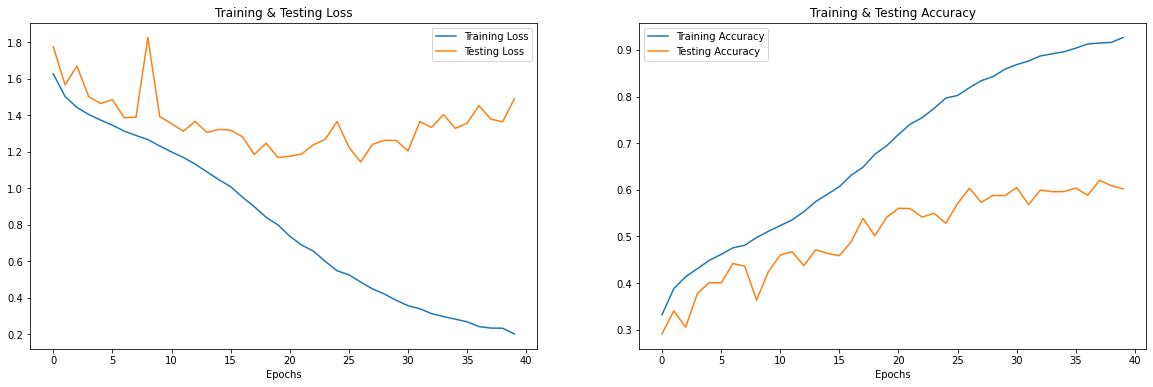

In [41]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral          fear
1             fear          fear
2            angry         angry
3          neutral       neutral
4             fear          fear
5             fear         happy
6            angry         happy
7            angry         angry
8             fear          fear
9          neutral       neutral